<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [122]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [123]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-02-16 21:23:50--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-02-16 21:23:55 (11.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [124]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [125]:
df.shape

(346, 10)

### Convert to date time object 

In [126]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [127]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following packages will be UPDATED:

    seaborn: 0.8.0-py35h15a2772_0 --> 0.9.0-py35_0 anaconda

seaborn-0.9.0- 100% |################################| Time: 0:00:00  51.88 MB/s


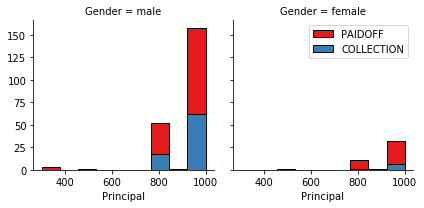

In [128]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

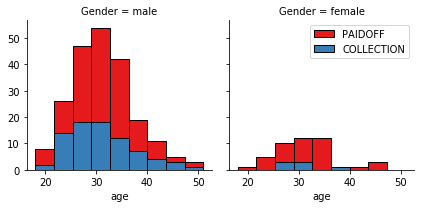

In [129]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

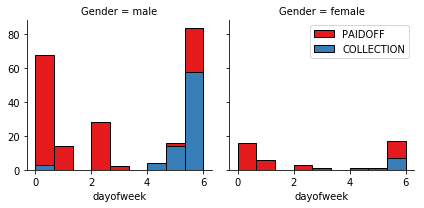

In [130]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [131]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [132]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [133]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [134]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [135]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [136]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()
#Feature.shape
#Feature.columns

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [137]:
X = Feature

X.shape

(346, 8)

What are our lables?

In [138]:
y = df['loan_status'].values
y.shape

(346,)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [139]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X.shape


(346, 8)

# Classification 

Now, ww wil use the training set to build an accurate model. Then use the test set to report the accuracy of the model
We have to use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



# K Nearest Neighbor(KNN)
Notice: we need to find the best k to build the model with the best accuracy.  
**warning:** We should not use the __loan_test.csv__ for finding the best k, however, we can split the train_loan.csv into train and test to find the best __k__.

In [140]:
from sklearn.model_selection import train_test_split
X_train, X_test_knn, y_train, y_test_knn = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test_knn.shape,  y_test_knn.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [141]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_similarity_score

Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh_knn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn=neigh_knn.predict(X_test_knn)
    mean_acc[n-1] = jaccard_similarity_score(y_test_knn, yhat_knn)

    
    std_acc[n-1]=np.std(yhat_knn==y_test_knn)/np.sqrt(yhat_knn.shape[0])

#mean_acc


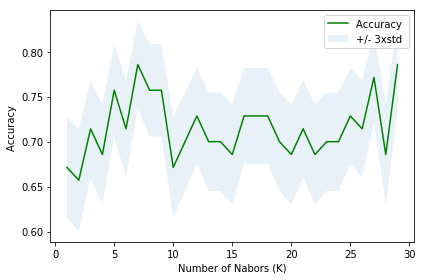

In [151]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()



In [152]:

k_knn = mean_acc.argmax()+1
j_index =  mean_acc.max() 

print( "The best accuracy (Jaccard Index score) on the training set is: ",j_index, "with k=",k_knn ) 
KNeighborsClassifier(n_neighbors = k_knn).fit(X_train,y_train)

The best accuracy (Jaccard Index score) on the training set is:  0.785714285714 with k= 7


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

# Decision Tree

In [144]:
from sklearn.tree import DecisionTreeClassifier

In [153]:
dec_tree = DecisionTreeClassifier(criterion="entropy", max_depth = None)
#dec_tree.fit(X_train_dt,y_train_dt)
dec_tree.fit(X,y)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [27]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    pydotplus: 2.0.2-py_2 conda-forge

pydotplus-2.0. 100% |################################| Time: 0:00:00  19.54 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    python-graphviz: 0.8.4-py35_2 conda-forge

python-graphvi 100% |################################| Time: 0:00:00  20.77 MB/s


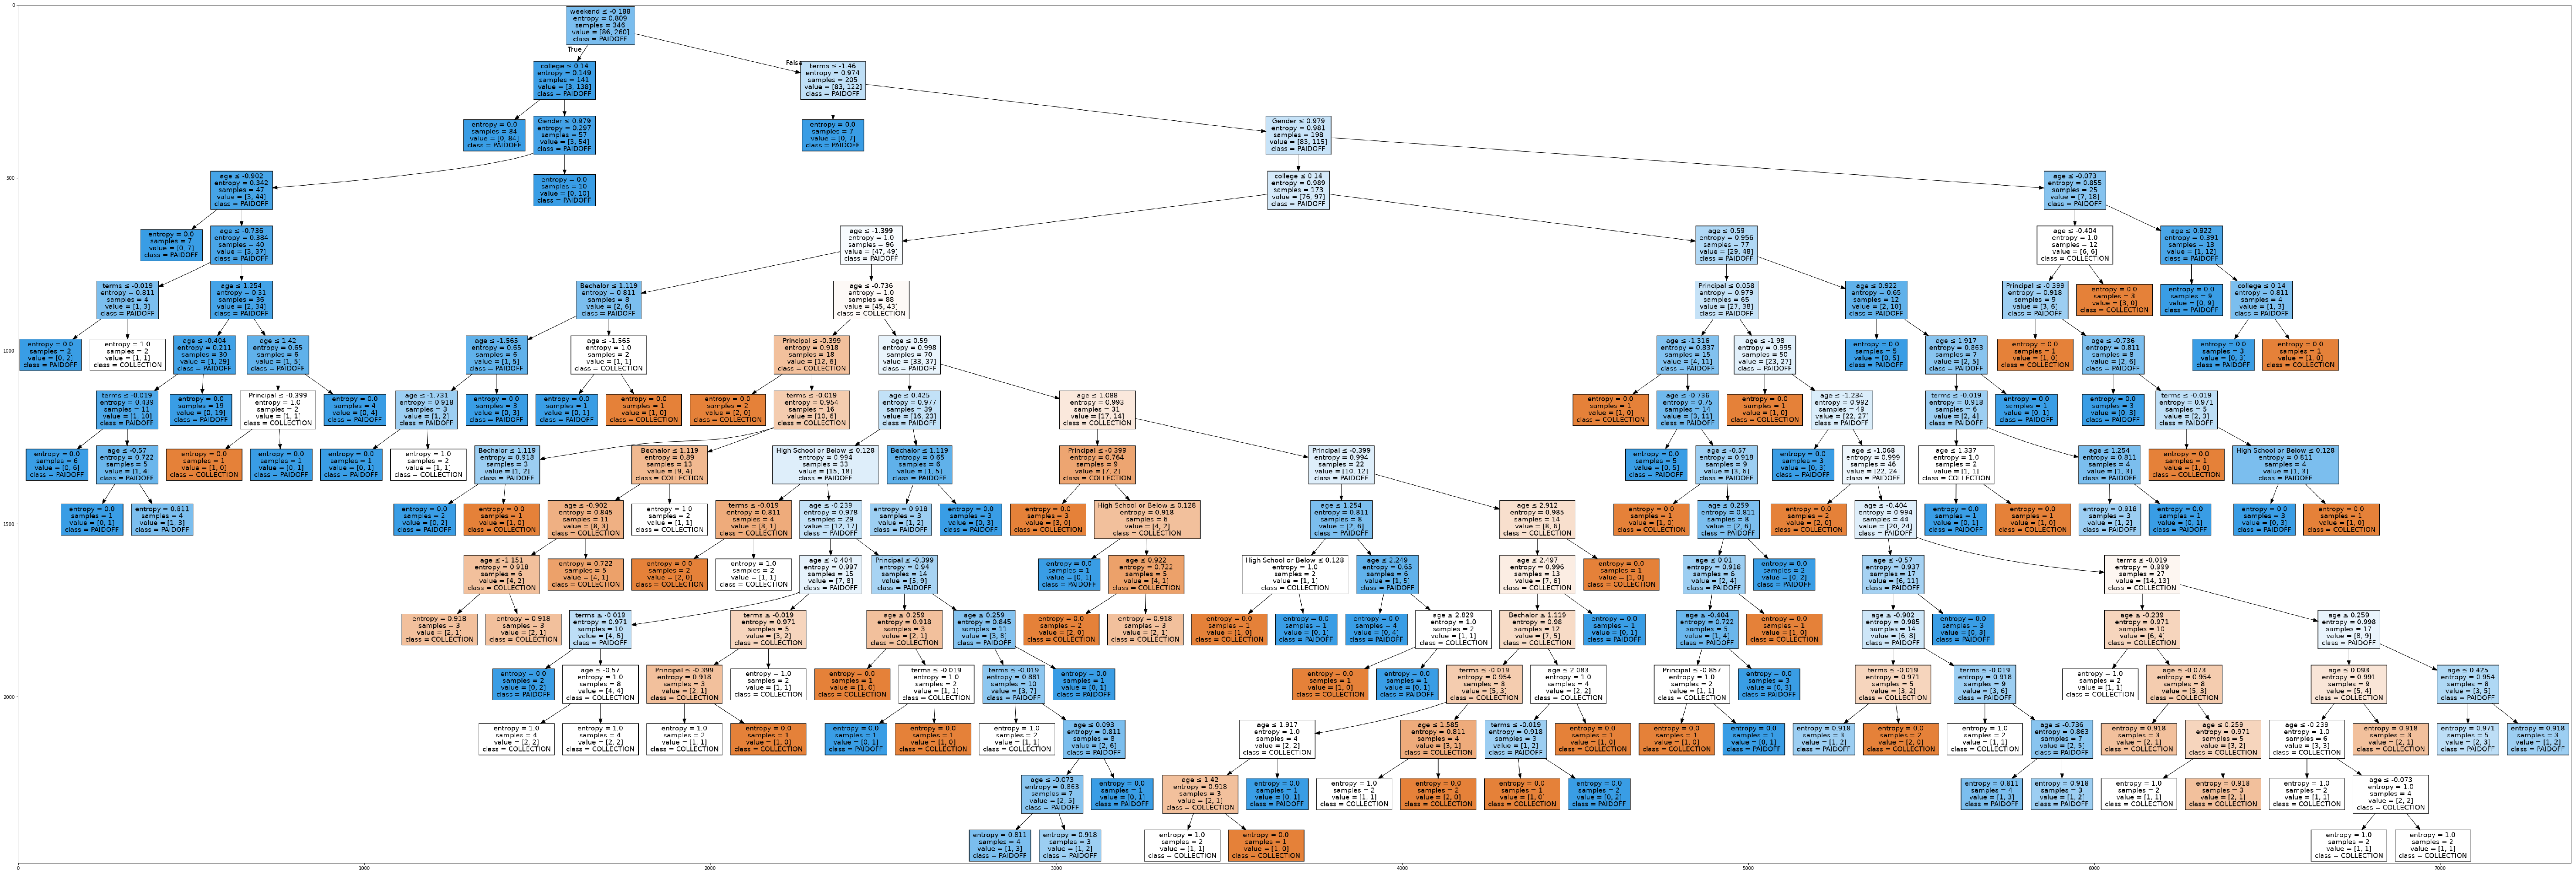

In [154]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

dot_data = StringIO()
filename = "dec_tree.png"
featureNames = Feature.columns
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(dec_tree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')



# Support Vector Machine

In [155]:
from sklearn import svm

clf = svm.SVC(kernel='rbf',gamma='auto')

clf.fit(X, y)




SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression

In [156]:
from sklearn.linear_model import LogisticRegression

# ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ 
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X,y)

LR

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Model Evaluation using Test set

In [50]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [51]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-02-16 20:33:47--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-02-16 20:33:52 (712 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [53]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


## Pre-processing the test dataset


In [54]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)


In [55]:
test_df['dayofweek'] = df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)


X_test = preprocessing.StandardScaler().fit(Feature_test).transform(Feature_test)
y_test = test_df['loan_status']
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


### K-Nearest Neighbor KNN


In [87]:
#k_knn
neigh = KNeighborsClassifier(n_neighbors = k_knn).fit(X,y) # Trained with all samples on the training set.
yhat=neigh.predict(X_test)
f1_knn = f1_score(y_test, yhat, average='weighted') 
print("F1 score is : %s" %f1_knn)
j_index_knn = jaccard_similarity_score(y_test, yhat)
print("Jaccard index is: %s" %j_index_knn)
set(y_test) - set(yhat)

F1 score is : 0.632840028189
Jaccard index is: 0.666666666667


set()

### Decision Tree

In [86]:

predTree = dec_tree.predict(X_test)

f1_dt = f1_score(y_test, predTree, average='weighted') 
print("F1 score is : %s" %f1_dt)
j_index_dt = jaccard_similarity_score(y_test, predTree)
print("Jaccard index is: %s" %j_index_dt)
set(y_test) - set(predTree)

F1 score is : 0.547479810638
Jaccard index is: 0.518518518519


set()

### Support Vector Machine

In [85]:
yhat_svm = clf.predict(X_test)

f1_svm = f1_score(y_test, yhat_svm, average='weighted') 
print("F1 score is : %s" %f1_svm)
j_index_svm = jaccard_similarity_score(y_test, yhat_svm)
print("Jaccard index is: %s" %j_index_svm)
yhat_svm.shape
#set(y_test) - set(yhat_svm)

F1 score is : 0.621266427718
Jaccard index is: 0.722222222222


set()

### Logistic Regression

In [121]:
yhat_lr = LR.predict(X_test)

f1_lr = f1_score(y_test, yhat_lr, average='weighted') 
print("F1 score is : %s" %f1_lr)
j_index_lr = jaccard_similarity_score(y_test, yhat_lr)
print("Jaccard index is: %s" %j_index_lr)

yhat_prob = LR.predict_proba(X_test)
#yhat_prob[0:5] 
log_loss_lr = log_loss(y_test, yhat_prob)
print("Logloss is: %s" %log_loss_lr)
#type(yhat_lr)
#yhat_lr.shape
#set(y_test) - set(yhat_lr)
#set(y_test)
#set(yhat_lr)
#yhat_lr
#yhat_prob

F1 score is : 0.630417651694
Jaccard index is: 0.740740740741
Logloss is: 0.670232469245


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
This is the  accuracy report of the built model using different evaluation metrics:

| Algorithm          | F1-score| Jaccard  | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.6328  | 0.6666   | NA      |
| Decision Tree      | 0.5474  | 0.5185   | NA      |
| SVM                | 0.6212  | 0.7222   | NA      |
| LogisticRegression | 0.6304  | 0.7407   | 0.6702  |